# Ensemble Network 


---


unweighted simple average voting


In [ ]:
pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 4.6MB/s 


Xception 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 24, 24, 32)   128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 24, 24, 32)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


224/224 [==============================] - 18s 62ms/step - loss: 1.0636 - acc: 0.2417 - val_loss: 1.0069 - val_acc: 0.1691

Epoch 00001: val_loss improved from inf to 1.00692, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_1.hdf5
Epoch 2/500
224/224 [==============================] - 13s 59ms/step - loss: 1.0019 - acc: 0.2906 - val_loss: 1.0216 - val_acc: 0.1691

Epoch 00002: val_loss did not improve from 1.00692
Epoch 3/500
224/224 [==============================] - 13s 59ms/step - loss: 0.9903 - acc: 0.2777 - val_loss: 1.0992 - val_acc: 0.2494

Epoch 00003: val_loss did not improve from 1.00692
Epoch 4/500
224/224 [==============================] - 13s 58ms/step - loss: 0.9340 - acc: 0.2947 - val_loss: 1.2169 - val_acc: 0.2494

Epoch 00004: val_loss did not improve from 1.00692
Epoch 5/500
224/224 [==============================] - 13s 59ms/step - loss: 0.9145 - acc: 0.3095 - val_loss: 0.9812 - val_acc: 0.2862

Epoch 00005: val_loss improved

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss 0.8125718832015991
Test Acc: 0.5773195624351501
113/113 [==============================] - 1s 6ms/step


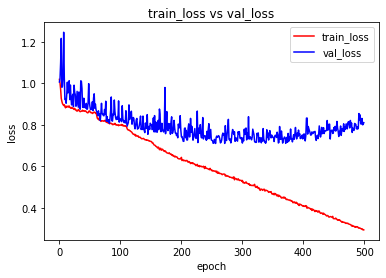

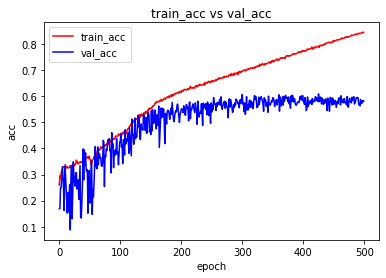

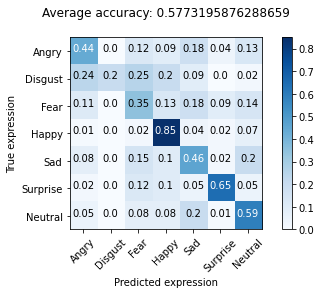

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 
import cv2

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 500

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)


#HE processing
def clahe_preprocessing(img: np.ndarray):
  list = []
  for rows in img:
    clahe_img = cv2.equalizeHist(rows)
    list.append(clahe_img)
  
  img_set = np.array(list)

  return img_set

# convert to float32 for data augmentation
X_train = clahe_preprocessing(X_train)
X_train = np.array(X_train, dtype=np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications import EfficientNetB0

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)
'''
def models(input_shape = (48, 48, 1)):

  # Xception
  model_1 = Xception(input_tensor = Input(input_shape), include_top= False, weights = None, pooling = max, classes = 7, classifier_activation = "softmax")

  return model_1
'''

def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

def exit_flow(x) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(7, activation='linear', activity_regularizer=l2(0.001))(x)
    
    return x

outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)
xception.summary()


opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model = xception
model.compile(loss="categorical_hinge", optimizer = opt, metrics = ["acc"])


from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


VGG16


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


224/224 [==============================] - 31s 103ms/step - loss: 2.1853 - acc: 0.2283 - val_loss: 1.8130 - val_acc: 0.2494

Epoch 00001: val_loss improved from inf to 1.81305, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5
Epoch 2/200
224/224 [==============================] - 23s 102ms/step - loss: 1.8189 - acc: 0.2508 - val_loss: 1.8115 - val_acc: 0.2494

Epoch 00002: val_loss improved from 1.81305 to 1.81149, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5
Epoch 3/200
224/224 [==============================] - 23s 102ms/step - loss: 1.8152 - acc: 0.2525 - val_loss: 1.8109 - val_acc: 0.2494

Epoch 00003: val_loss improved from 1.81149 to 1.81093, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5
Epoch 4/200
224/224 [==============================] - 23s 101ms/step - loss: 1.8115 - acc: 0.2503 - val_loss: 1.8151 - val_acc: 0.2494

Epoch 000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss 1.815049409866333
Test Acc: 0.24491502344608307
113/113 [==============================] - 2s 10ms/step


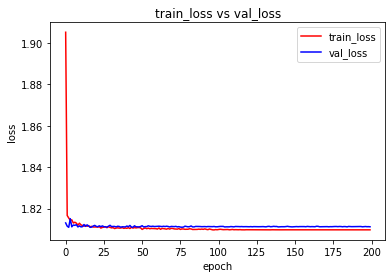

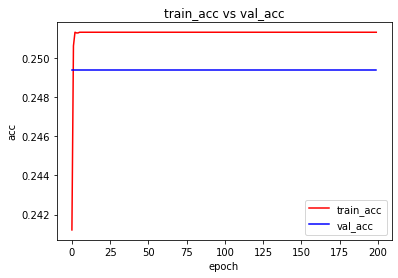

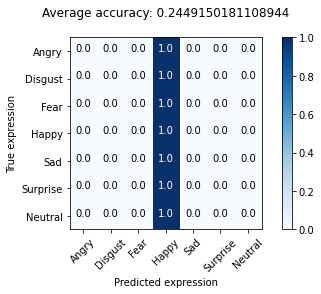

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model, Sequential 
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications import EfficientNetB0

input_shape = (48, 48, 1)


model = keras.applications.vgg16.VGG16(input_shape = input_shape, weights= None, include_top = False)

x = model.output 
x = Dropout(0.7)(x)
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["acc"])
model.summary()

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_2.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


**ResNet50**

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
224/224 [==============================] - 37s 110ms/step - loss: 2.7761 - acc: 0.2122 - val_loss: 1.8647 - val_acc: 0.2494

Epoch 00001: val_loss improved from inf to 1.86471, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_3.hdf5
Epoch 2/200
224/224 [==============================] - 23s 104ms/step - loss: 2.2314 - acc: 0.2539 - val_loss: 1469.9375 - val_acc: 0.1265

Epoch 00002: val_loss did not improve from 1.86471
Epoch 3/200
224/224 [==============================] - 24s 105ms/step - loss: 2.1289 - acc: 0.2519 - val_loss: 6.8986 - val_acc: 0.2875

Epoch 00003: val_loss did not improve from 1.86471
Epoch 4/200
224/224 [==============================] - 24s 106ms/step - loss: 1.9988 - acc: 0.2826 - val_loss: 1.7615 - val_acc: 0.2705

Epoch 00004: val_loss improved from 1.86471 to 1.76151, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_3.hdf5
Epoch 5/200
224/224 [========================

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss 2.00118088722229
Test Acc: 0.5750905275344849
113/113 [==============================] - 2s 12ms/step


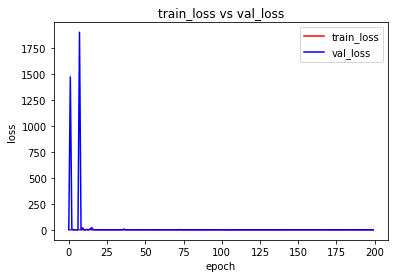

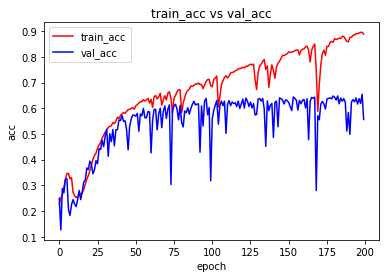

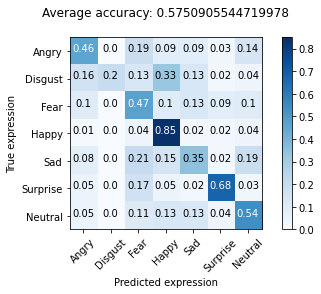

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model, Sequential 
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications import EfficientNetB0

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)



model = keras.applications.resnet.ResNet50(weights=None, include_top=False, input_shape=input_shape)
x = model.output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)
opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["acc"])
model.summary()

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_3.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_3.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


**MobileNetV2**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   288         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 24, 24, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


224/224 [==============================] - 17s 61ms/step - loss: 2.0074 - acc: 0.2052 - val_loss: 1.9078 - val_acc: 0.1819

Epoch 00001: val_loss improved from inf to 1.90784, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_5.hdf5
Epoch 2/200
224/224 [==============================] - 13s 59ms/step - loss: 1.8017 - acc: 0.2783 - val_loss: 1.8382 - val_acc: 0.1819

Epoch 00002: val_loss improved from 1.90784 to 1.83824, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_5.hdf5
Epoch 3/200
224/224 [==============================] - 13s 59ms/step - loss: 1.6931 - acc: 0.3291 - val_loss: 1.8355 - val_acc: 0.2494

Epoch 00003: val_loss improved from 1.83824 to 1.83555, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_5.hdf5
Epoch 4/200
224/224 [==============================] - 13s 58ms/step - loss: 1.6225 - acc: 0.3665 - val_loss: 1.8797 - val_acc: 0.2494

Epoch 00004: 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss 1.799061894416809
Test Acc: 0.6277514696121216
113/113 [==============================] - 1s 4ms/step


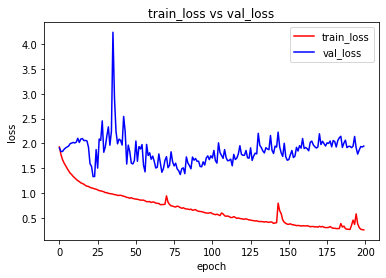

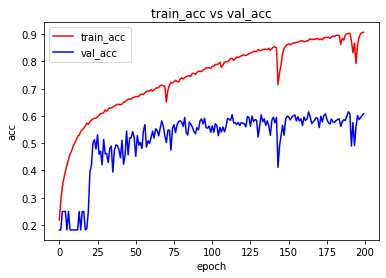

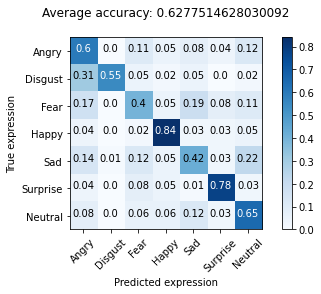

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model, Sequential 
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications import EfficientNetB0

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)



model = keras.applications.MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)
opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["acc"])
model.summary()

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_5.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_5.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


VGG16

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


224/224 [==============================] - 30s 97ms/step - loss: 3.7926 - acc: 0.2449 - val_loss: 1.8123 - val_acc: 0.2494

Epoch 00001: val_loss improved from inf to 1.81234, saving model to /content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5
Epoch 2/200
224/224 [==============================] - 21s 95ms/step - loss: 1.8132 - acc: 0.2508 - val_loss: 1.8159 - val_acc: 0.2494

Epoch 00002: val_loss did not improve from 1.81234
Epoch 3/200
224/224 [==============================] - 21s 95ms/step - loss: 1.8139 - acc: 0.2477 - val_loss: 1.8126 - val_acc: 0.2494

Epoch 00003: val_loss did not improve from 1.81234
Epoch 4/200
224/224 [==============================] - 21s 96ms/step - loss: 1.8102 - acc: 0.2517 - val_loss: 1.8134 - val_acc: 0.2494

Epoch 00004: val_loss did not improve from 1.81234
Epoch 5/200
224/224 [==============================] - 22s 98ms/step - loss: 1.8148 - acc: 0.2448 - val_loss: 1.8145 - val_acc: 0.2494

Epoch 00005: val_loss did not 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss 1.815123200416565
Test Acc: 0.24491502344608307
113/113 [==============================] - 2s 11ms/step


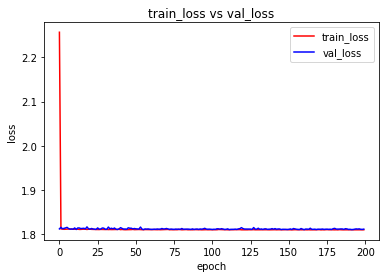

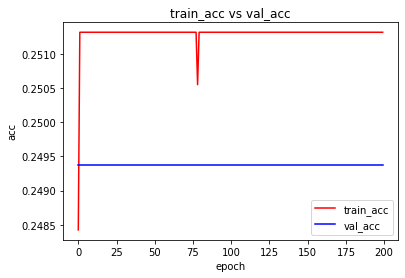

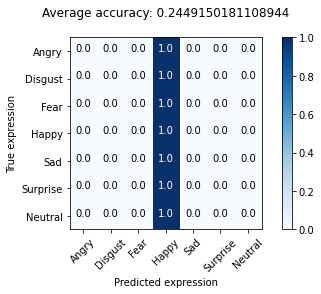

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model, Sequential 
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications import EfficientNetB0

input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)



model = keras.applications.vgg16.VGG16(weights=None, include_top=False, input_shape=input_shape)
x = model.output
x = Flatten()(x)
x = Dense(units = 4096)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)
opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["acc"])
model.summary()

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_2.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_2.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


**Inception V3**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model, Sequential 
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# CNN Construction
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#import efficientnet.keras as efn 


input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

model = keras.applications.inception_v3.InceptionV3(weights=None, include_top=False, input_shape=inputs)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)
opt = Adam(lr=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7, decay = 1e-6)
model.compile(loss="categorical_crossentropy", optimizer = opt, metrics = ["acc"])
model.summary()

from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_4.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_4.hdf5')

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


TypeError: ignored

**Ensemble Model Performance Experiment**




In [ ]:
pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 4.7MB/s 


Model: "Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
Xception (Functional)           (None, 7)            3989975     input_6[0][0]                    
__________________________________________________________________________________________________
ResNet50 (Functional)           (None, 7)            23595783    input_6[0][0]                    
__________________________________________________________________________________________________
DenseNet121 (Functional)        (None, 7)            7038407     input_6[0][0]                    
___________________________________________________________________________________________

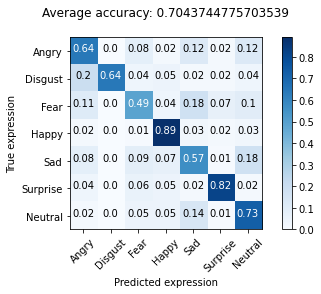

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 
import cv2 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.python.keras.models import load_model
from keras.models import Model, Sequential
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization, Input, Average
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# Ensemble Construction
input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

# load efficientnet
import efficientnet.keras 
def ensemble():

    model_1 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/Xception.hdf5")
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/ResNet50.hdf5")
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'ResNet50')

    model_3 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/DenseNet121.hdf5")
    model_3 = Model(inputs = model_3.inputs, outputs = model_3.outputs, name = 'DenseNet121')

    model_4 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/MobileNetV2.hdf5")
    model_4 = Model(inputs = model_4.inputs, outputs = model_4.outputs, name = 'MobileNetV2')

    model_5 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/EfficientNetB0.hdf5")
    model_5 = Model(inputs = model_5.inputs, outputs = model_5.outputs, name = 'EfficientNetB0')

    models = [model_1, model_2, model_3, model_4, model_5]


    models_input = inputs
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average


model = ensemble()
model.summary()
model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/simple_average.hdf5')


'''
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/weights_min_loss_4.hdf5"
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, verbose = 0, mode = "max")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)


train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.figure()

loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

model.save('/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/FER2013_4.hdf5')
'''
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


Soft Voting Ensemble


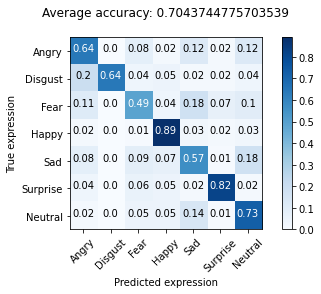

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.misc 
import itertools 
import h5py 
import tensorflow 
import cv2 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.python.keras.models import load_model
from keras.models import Model, Sequential
from keras.optimizers import Adam 
from keras.regularizers import l1,l2 
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D 
from keras.layers import BatchNormalization, Input, Average
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from math import sqrt
from sklearn.metrics import confusion_matrix
from IPython.display import display 
from google.colab import files

# Produce stable results 
from numpy.random import seed
from tensorflow import random 

seed(1)
tensorflow.random.set_seed(1)

# Control Variables
batch_size = 128
num_epochs = 200

# Set path
path = "/content/drive/My Drive/Colab Notebooks/FER2013/fer2013.csv"
data = pd.read_csv(path)

# Preprocess dataset
num_classes = 7
width, height = 48, 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
 
train_data = data[(data.Usage == "Training")]
val_data = data[(data.Usage == "PublicTest")]
test_data = data[(data.Usage == "PrivateTest")]

# convert to 2D ndarray n(48*48)
X_train = np.array(list(map(str.split, train_data.pixels)), np.uint8)
X_val = np.array(list(map(str.split, val_data.pixels)), np.float32)
X_test = np.array(list(map(str.split, test_data.pixels)), np.float32)


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

y_train = train_data.emotion
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = val_data.emotion
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = test_data.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    fill_mode = 'nearest',
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

test_gen = ImageDataGenerator( 
    rescale=1./255,
    )

data_gen.fit(X_train)

train_flow = data_gen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = test_gen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size) 

# Ensemble Construction
input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

# load efficientnet
import efficientnet.keras 
def ensemble():

    model_1 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/Xception.hdf5")
    model_2 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/ResNet50.hdf5")
    model_3 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/DenseNet121.hdf5") 
    model_4 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/MobileNetV2.hdf5")
    model_5 = load_model("/content/drive/My Drive/Colab Notebooks/FER2013/ensemble/EfficientNetB0.hdf5")

    models = [model_1, model_2, model_3, model_4, model_5]
    models = list(reversed(models))

    return models

models = ensemble()

# Soft Voting
def ensemble_prediction():
  pred = [model.predict(X_test/255) for model in models]
  pred = np.asarray(pred)

  # sum soft voting
  votes = np.sum(pred, axis = 0)

  # get max vote
  vote = np.argmax(votes, axis = 1)

  return vote

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

y_pred = ensemble_prediction()
t_te = np.argmax(y_test, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')
